## Notebook Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb

## Gathering Data

In [2]:
df = pd.read_csv('nyc_orsm.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_wo_trafick,duration_wo_trafick
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2159.3,232.7
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2512.9,336.1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,9934.4,898.5
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1777.6,242.7
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1606.6,194.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   id                   1458644 non-null  object 
 1   vendor_id            1458644 non-null  int64  
 2   pickup_datetime      1458644 non-null  object 
 3   dropoff_datetime     1458644 non-null  object 
 4   passenger_count      1458644 non-null  int64  
 5   pickup_longitude     1458644 non-null  float64
 6   pickup_latitude      1458644 non-null  float64
 7   dropoff_longitude    1458644 non-null  float64
 8   dropoff_latitude     1458644 non-null  float64
 9   store_and_fwd_flag   1458644 non-null  object 
 10  trip_duration        1458644 non-null  int64  
 11  distance_wo_trafick  1458627 non-null  float64
 12  duration_wo_trafick  1458627 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 144.7+ MB


In [4]:
df.isna().sum()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
store_and_fwd_flag      0
trip_duration           0
distance_wo_trafick    17
duration_wo_trafick    17
dtype: int64

## Data Preparation

In [5]:
df_temp = df.copy()
df_temp.drop('dropoff_datetime', axis=1, inplace=True)

#### Handling time data

In [6]:
df_temp['pickup_datetime'] = pd.to_datetime(df_temp['pickup_datetime'])
df_temp['pickup_datetime'] = df_temp['pickup_datetime']
df_temp['pickup_timestamp'] = (df_temp['pickup_datetime'] - pd.Timestamp('1970-1-1')) // pd.Timedelta('1s')

In [7]:
df_temp['day_of_the_week'] = df_temp['pickup_datetime'].dt.day_name()
df_temp['month'] = df_temp['pickup_datetime'].dt.month
df_temp['hour_of_day'] = df_temp['pickup_datetime'].dt.hour

In [8]:
def is_holiday(day):
    if day == 'Saturday' or day == 'Sunday':
        return True
    else:
        return False

In [9]:
df_temp['is_holiday'] = False
df_temp['is_holiday'] = df_temp['day_of_the_week'].apply(is_holiday)

holidays = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30']

for date in holidays:
    date = pd.to_datetime(date, errors='coerce').date()
    df_temp.loc[df_temp['pickup_datetime'].dt.date == date, 'is_holiday'] = True

#### Checking if at any point the taxi has passed the city center

In [10]:
def haversine_distance(lat1, lon1, lat2, lon2):
   
    earth_radius = 6371     
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
   
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = earth_radius * c

    return distance

In [11]:
def has_crossed_center(row):
    start_to_center = haversine_distance(row['pickup_latitude'], row['pickup_longitude'], center_lat, center_lon)
    end_to_center = haversine_distance(row['dropoff_latitude'], row['dropoff_longitude'], center_lat, center_lon)
    total_distance = haversine_distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])
    return (start_to_center < total_distance) and (end_to_center < total_distance)

In [12]:
center_lat = 40.7128
center_lon = -74.0060

df_temp['crossed_center'] = df_temp.apply(has_crossed_center, axis=1)

In [13]:
lat_pickup = df_temp['pickup_latitude'].to_numpy()
lat_dropoff = df_temp['dropoff_latitude'].to_numpy()
lon_pickup = df_temp['pickup_longitude'].to_numpy()
lon_dropoff = df_temp['dropoff_longitude'].to_numpy()

distances_pickup_dropoff = haversine_distance(lat_pickup, lon_pickup, lat_dropoff, lon_dropoff)

df_temp['speed'] = distances_pickup_dropoff/(df_temp['trip_duration']/3600)
df_temp.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

## Encoding Categorical Data

In [14]:
df_eda = df_temp.copy()
distances_pickup_center = haversine_distance(lat_pickup, lon_pickup, np.array(center_lat), np.array(center_lon))
distances_dropoff_center = haversine_distance(lat_dropoff, lon_dropoff, np.array(center_lat), np.array(center_lon))
df_eda['distance_pickup_dropoff'] = distances_pickup_dropoff
df_eda['center_to_pickup'] = distances_pickup_center
df_eda['center_to_dropoff'] = distances_dropoff_center
df_temp = pd.get_dummies(df_temp, columns=['day_of_the_week', 'month', 'store_and_fwd_flag', 'is_holiday', 'crossed_center'])
df_temp.drop('pickup_datetime', axis=1, inplace=True)

#### I made a seperate dataframe with some feautres added for better visualization

## EDA

C:\Users\Asus\AppData\Local\Temp\ipykernel_6940\559093268.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(subset.corr(), annot=True, cmap='Pastel1');


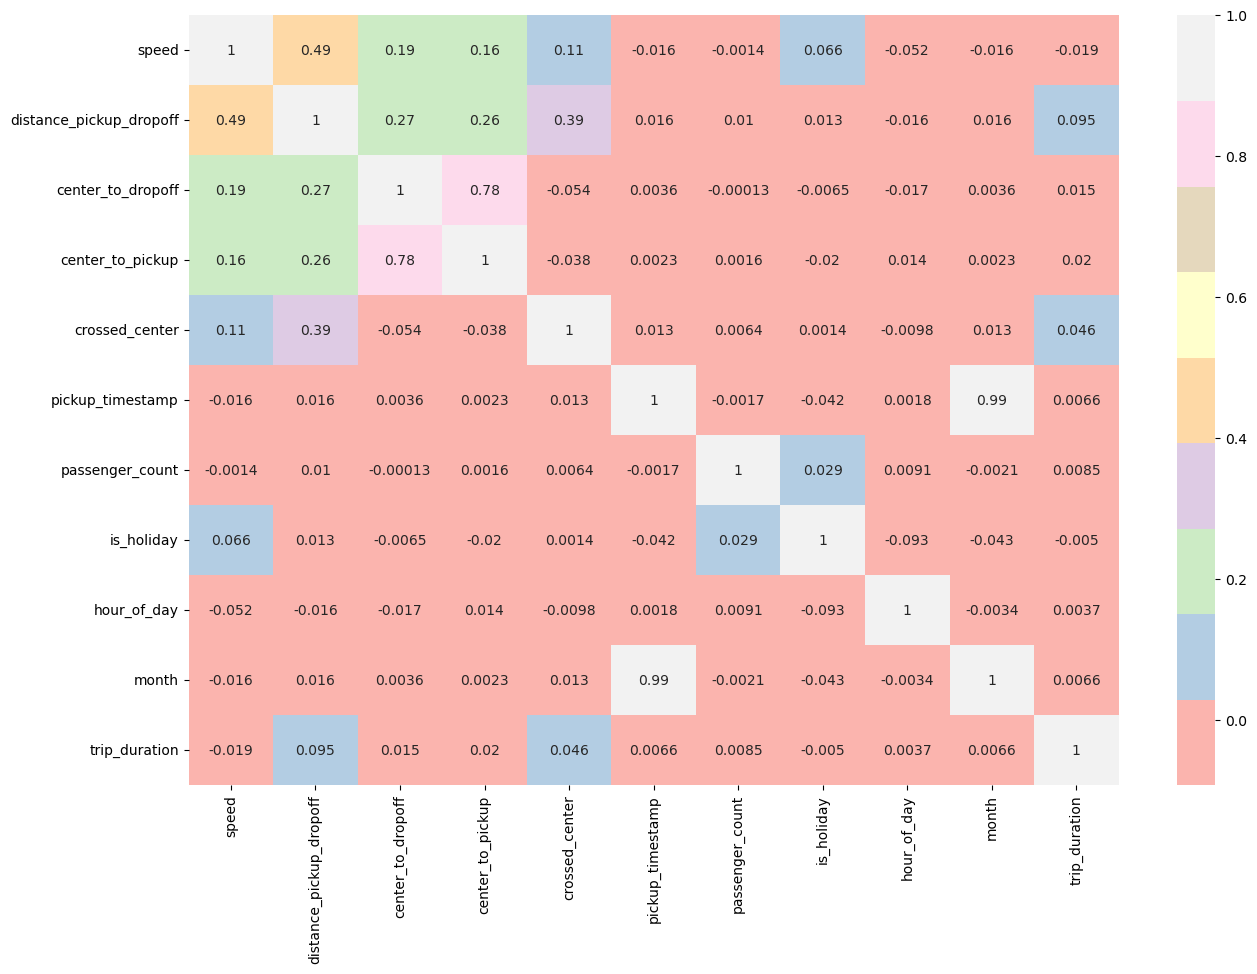

In [15]:
plt.figure(figsize=(15, 10))
columns = ['speed', 'distance_pickup_dropoff', 'center_to_dropoff', 'center_to_pickup', 'crossed_center', 'pickup_timestamp', 'passenger_count','is_holiday', 'hour_of_day', 'day_of_the_week', 'month', 'trip_duration']
subset = df_eda[columns]
sns.heatmap(subset.corr(), annot=True, cmap='Pastel1');

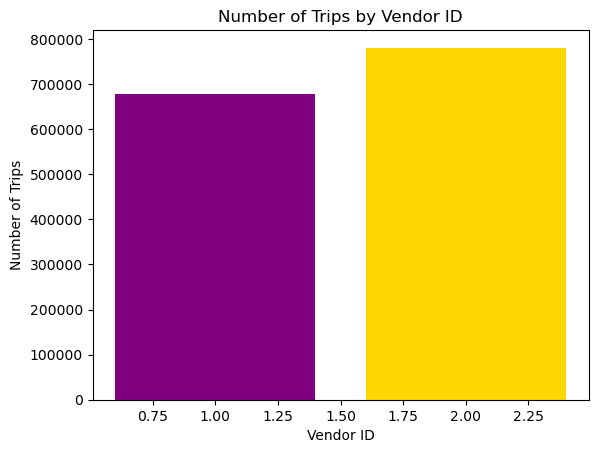

In [16]:
trips_by_vendor = df_eda.groupby('vendor_id')['trip_duration'].count()

plt.bar(trips_by_vendor.index, trips_by_vendor.values, color=['purple', 'gold'])
plt.xlabel('Vendor ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Vendor ID')
plt.show()

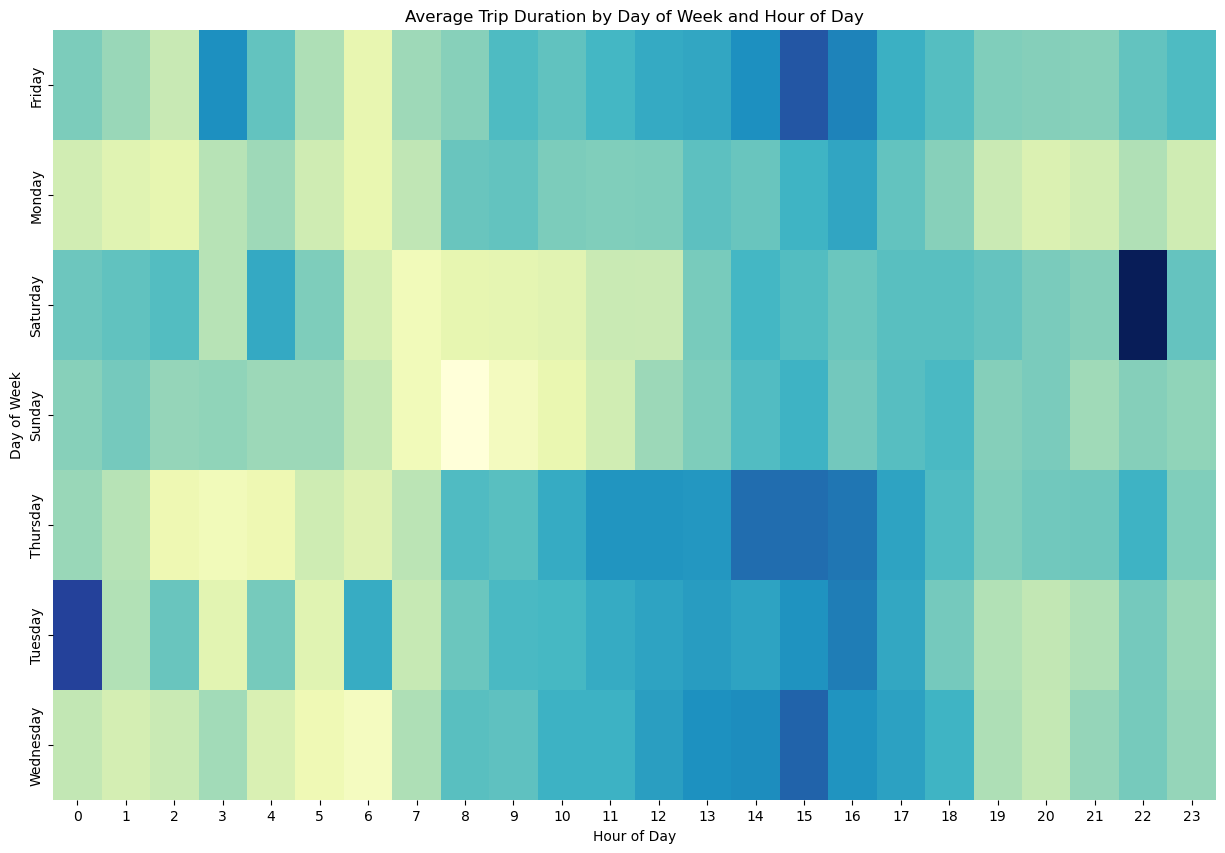

In [17]:
plt.figure(figsize=(15, 10))

pivot_table = df_eda.pivot_table(values='trip_duration', index='day_of_the_week', columns='hour_of_day', aggfunc='mean')

sns.heatmap(pivot_table, cmap='YlGnBu', cbar=False)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average Trip Duration by Day of Week and Hour of Day')
plt.show()

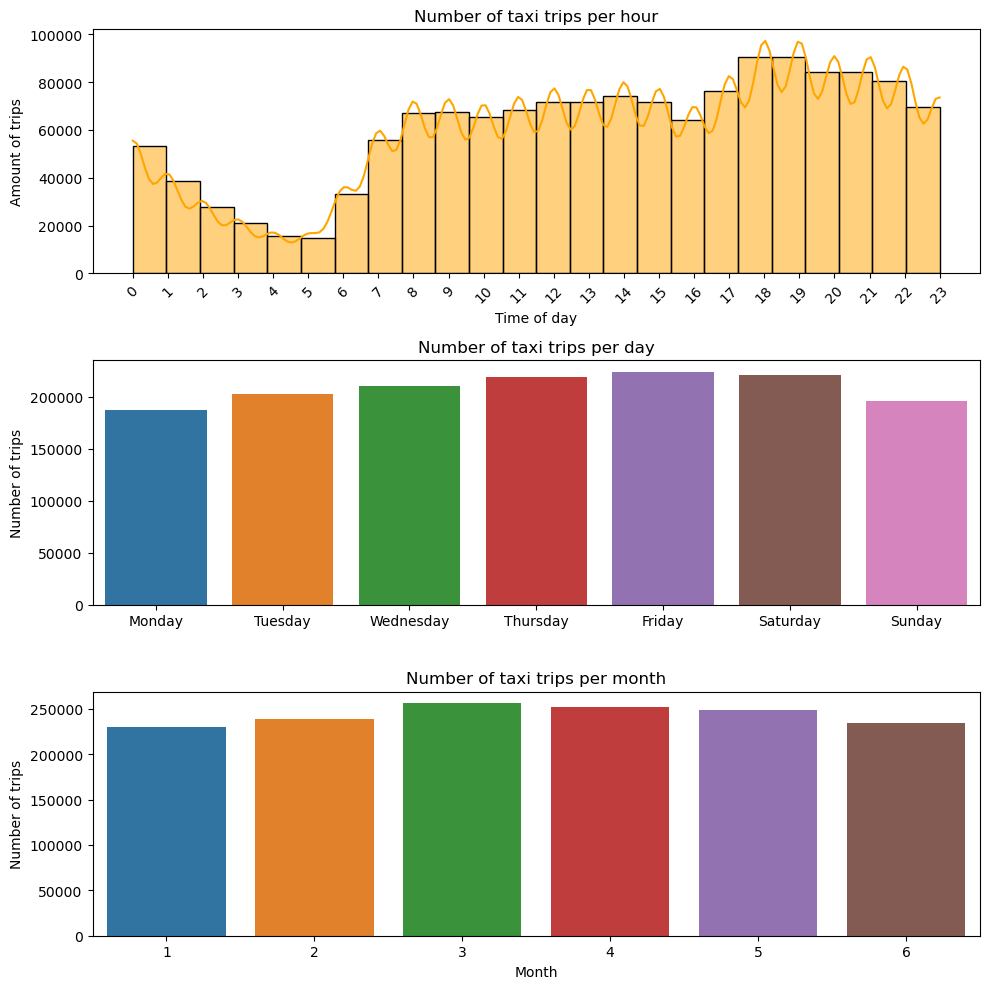

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

sns.histplot(data=df_eda, x='hour_of_day', bins=24, color='orange', kde=True, ax=ax[0])
ax[0].set_title('Number of taxi trips per hour')
ax[0].set_xlabel('Time of day')
ax[0].set_ylabel('Amount of trips')
hourly_labels = list(range(max(df_eda['hour_of_day']) + 1))
hourly_positions = list(range(max(df_eda['hour_of_day']) + 1))
ax[0].set_xticks(hourly_positions)
ax[0].set_xticklabels(hourly_labels, rotation=45)

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df_eda, x='day_of_the_week', ax=ax[1], order=weekday_order)
ax[1].set_title('Number of taxi trips per day')
ax[1].set_ylabel('Number of trips')
ax[1].set_xlabel('')

sns.countplot(data=df_eda, x='month', ax=ax[2])
ax[2].set_title('Number of taxi trips per month')
ax[2].set_xlabel('Month')
ax[2].set_ylabel('Number of trips')

plt.subplots_adjust(left=0.1, right=0.9) 
plt.tight_layout()

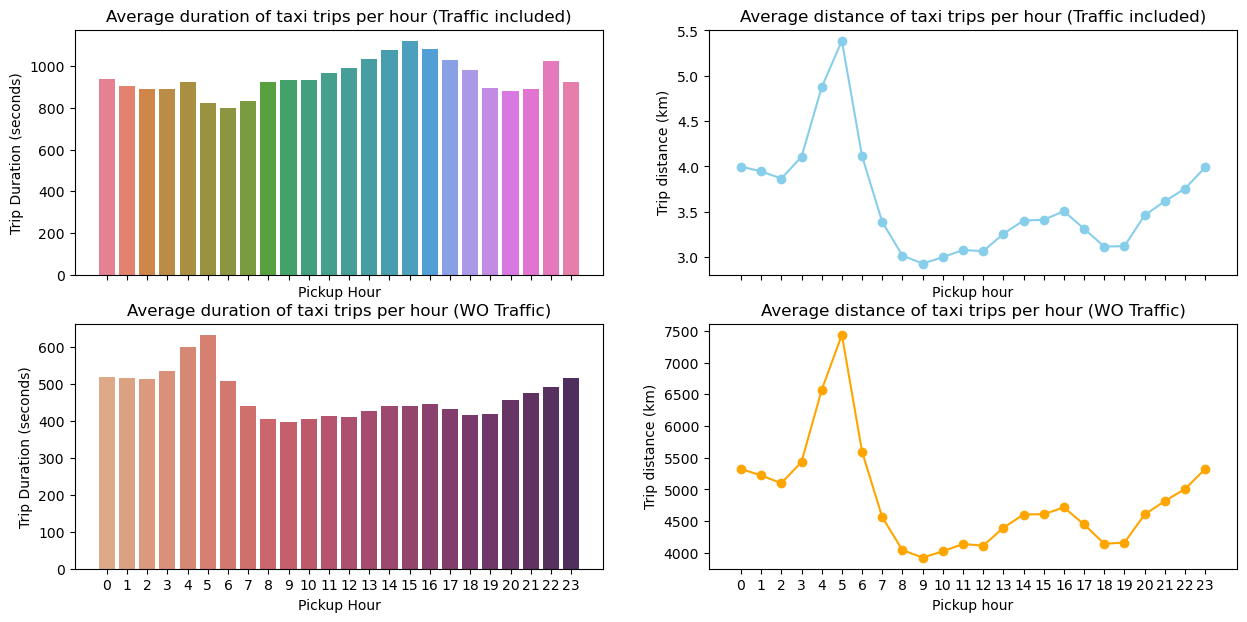

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharex=True)

hour_group = df_eda.groupby('hour_of_day').trip_duration.mean()
sns.barplot(x=hour_group.index, y=hour_group.values, ax=ax[0, 0], palette=sns.color_palette("husl", len(range(0, 24))))
ax[0, 0].set_title('Average duration of taxi trips per hour (Traffic included)')
ax[0, 0].set_ylabel('Trip Duration (seconds)')
ax[0, 0].set_xlabel('Pickup Hour')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels())

hour_group = df_eda.groupby('hour_of_day').distance_pickup_dropoff.mean()
ax[0, 1].plot(hour_group.index, hour_group.values, color='skyblue', marker='o')
ax[0, 1].set_title('Average distance of taxi trips per hour (Traffic included)')
ax[0, 1].set_ylabel('Trip distance (km)')
ax[0, 1].set_xlabel('Pickup hour')


hour_group = df_eda.groupby('hour_of_day').duration_wo_trafick.mean()
sns.barplot(x=hour_group.index, y=hour_group.values, ax=ax[1, 0], palette=sns.color_palette("flare", len(range(0, 24))))
ax[1, 0].set_title('Average duration of taxi trips per hour (WO Traffic)')
ax[1, 0].set_ylabel('Trip Duration (seconds)')
ax[1, 0].set_xlabel('Pickup Hour')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels())

hour_group = df_eda.groupby('hour_of_day').distance_wo_trafick.mean()
ax[1, 1].plot(hour_group.index, hour_group.values, color='orange', marker='o')
ax[1, 1].set_title('Average distance of taxi trips per hour (WO Traffic)')
ax[1, 1].set_ylabel('Trip distance (km)')
ax[1, 1].set_xlabel('Pickup hour')
plt.show()

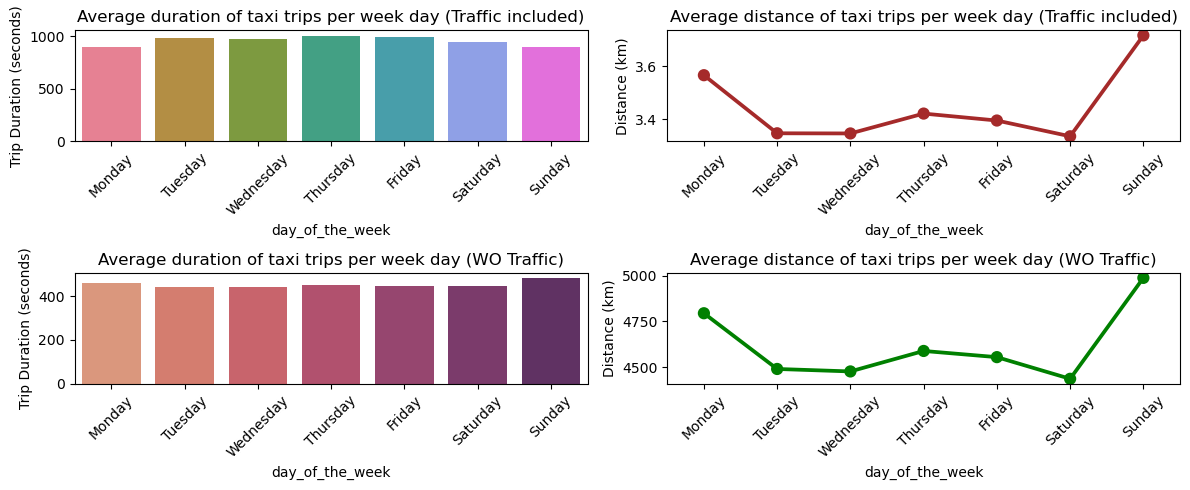

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))

labels = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

week_group = df_eda.groupby('day_of_the_week').trip_duration.mean()
sns.barplot(x=week_group.index, y=week_group.values, order=weekday_order, ax=ax[0, 0], palette=sns.color_palette("husl", len(weekday_order)))
ax[0, 0].set_title('Average duration of taxi trips per week day (Traffic included)')
ax[0, 0].set_ylabel('Trip Duration (seconds)')
ax[0, 0].set_xticklabels(weekday_order, rotation=45)

week_group = df_eda.groupby('day_of_the_week').distance_pickup_dropoff.mean()
sns.pointplot(x=week_group.index, y=week_group.values, color='brown', order=weekday_order, ax=ax[0, 1])
ax[0, 1].set_title('Average distance of taxi trips per week day (Traffic included)')
ax[0, 1].set_ylabel('Distance (km)')
ax[0, 1].set_xticklabels(weekday_order, rotation=45);

week_group = df_eda.groupby('day_of_the_week').duration_wo_trafick.mean()
sns.barplot(x=week_group.index, y=week_group.values, order=weekday_order, ax=ax[1, 0], palette=sns.color_palette("flare", len(weekday_order)))
ax[1, 0].set_title('Average duration of taxi trips per week day (WO Traffic)')
ax[1, 0].set_ylabel('Trip Duration (seconds)')
ax[1, 0].set_xticklabels(weekday_order, rotation=45)

week_group = df_eda.groupby('day_of_the_week').distance_wo_trafick.mean()
sns.pointplot(x=week_group.index, y=week_group.values, color='green', order=weekday_order, ax=ax[1, 1])
ax[1, 1].set_title('Average distance of taxi trips per week day (WO Traffic)')
ax[1, 1].set_ylabel('Distance (km)')
ax[1, 1].set_xticklabels(weekday_order, rotation=45);
plt.subplots_adjust()
plt.tight_layout()

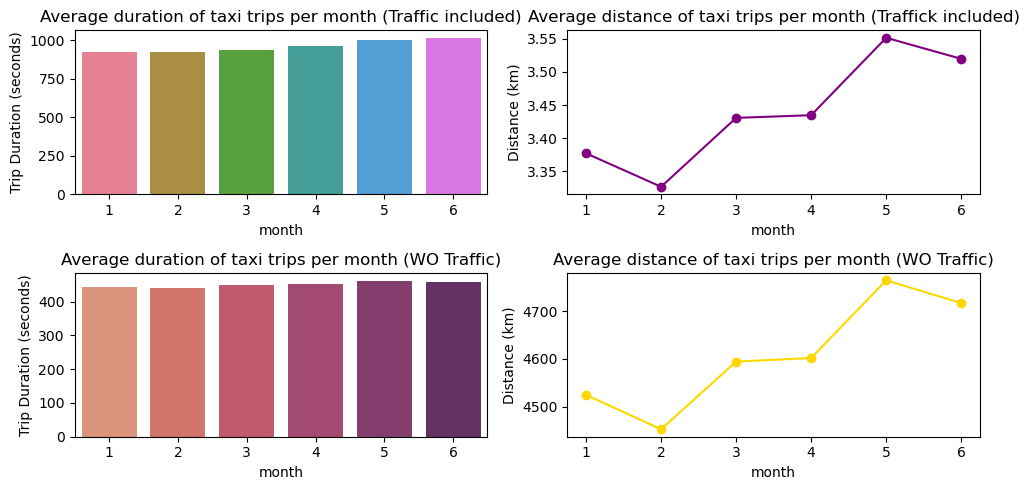

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

month_group = df_eda.groupby('month').trip_duration.mean()
month_group = pd.Series(month_group.values, index=month_group.index)

sns.barplot(x=month_group.index, y=month_group.values, palette=sns.color_palette("husl", len(range(1, 7))), ax=ax[0, 0])
ax[0, 0].set_title('Average duration of taxi trips per month (Traffic included)')
ax[0, 0].set_ylabel('Trip Duration (seconds)')
ax[0, 0].set_xlabel('month')

month_group = df_eda.groupby('month').distance_pickup_dropoff.mean()
month_group = pd.Series(month_group.values, index=month_group.index)

ax[0, 1].plot(month_group.index, month_group.values, color='purple', marker='o')
ax[0, 1].set_title('Average distance of taxi trips per month (Traffick included)')
ax[0, 1].set_ylabel('Distance (km)')
ax[0, 1].set_xlabel('month')

month_group = df_eda.groupby('month').duration_wo_trafick.mean()
month_group = pd.Series(month_group.values, index=month_group.index)

sns.barplot(x=month_group.index, y=month_group.values, palette=sns.color_palette("flare", len(range(1, 7))), ax=ax[1, 0])
ax[1, 0].set_title('Average duration of taxi trips per month (WO Traffic)')
ax[1, 0].set_ylabel('Trip Duration (seconds)')
ax[1, 0].set_xlabel('month')

month_group = df_eda.groupby('month').distance_wo_trafick.mean()
month_group = pd.Series(month_group.values, index=month_group.index)

ax[1, 1].plot(month_group.index, month_group.values, color='gold', marker='o')
ax[1, 1].set_title('Average distance of taxi trips per month (WO Traffic)')
ax[1, 1].set_ylabel('Distance (km)')
ax[1, 1].set_xlabel('month')

plt.tight_layout()
plt.subplots_adjust()

<Figure size 1000x600 with 0 Axes>

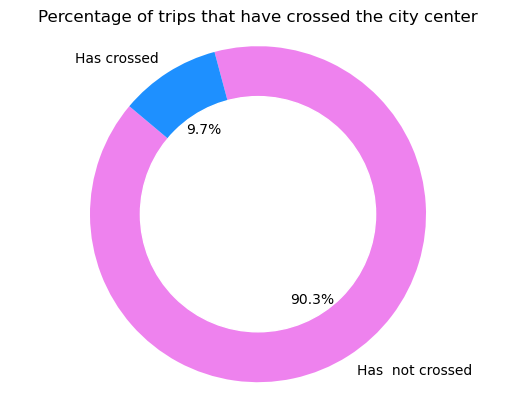

In [22]:
count_1 = df_eda['crossed_center'].sum()
count_0 = len(df_eda) - count_1
labels = ['Has  not crossed', 'Has crossed']
sizes = [count_0, count_1]
colors=['violet', 'dodgerblue']
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
plt.title('Percentage of trips that have crossed the city center')
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
center_circle = plt.Circle((0, 0), 0.70, color='white')
ax.add_artist(center_circle)
ax.axis('equal');

C:\Users\Asus\AppData\Local\Temp\ipykernel_6940\1807640745.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels, rotation=45)


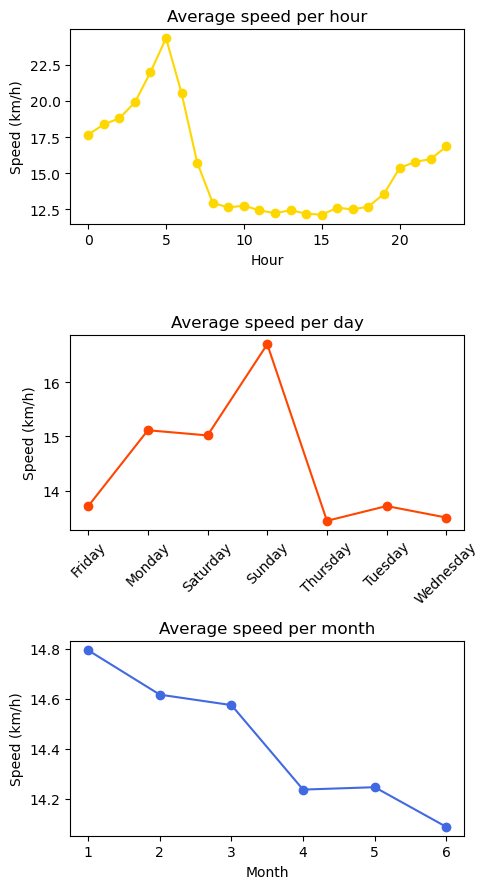

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 9))
labels = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

speed_hour = df_eda.groupby('hour_of_day').speed.mean()
speed_day = df_eda.groupby('day_of_the_week').speed.mean()
speed_month = df_eda.groupby('month').speed.mean()

ax[0].plot(speed_hour.index, speed_hour.values, marker='o', color='gold')
ax[0].set_title('Average speed per hour')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Speed (km/h)')

ax[1].plot(speed_day.index, speed_day.values, marker='o', color='orangered')
ax[1].set_title('Average speed per day')
ax[1].set_ylabel('Speed (km/h)')
ax[1].set_xticklabels(labels, rotation=45)

ax[2].plot(speed_month.index, speed_month.values, marker='o', color='royalblue')
ax[2].set_title('Average speed per month')
ax[2].set_xlabel('Month')
ax[2].set_ylabel('Speed (km/h)')

plt.tight_layout()

## Preprocessing

### Removing outliers with the IQR method

In [24]:
df_temp['trip_duration'].skew()

343.1639435917362

#### Our labels do not have a normal distribution, will try to reduce the skew with LOG

In [25]:
df_temp['trip_duration'] = np.log(df_temp['trip_duration'])
df_temp['trip_duration'].skew()

-0.34070423044801745

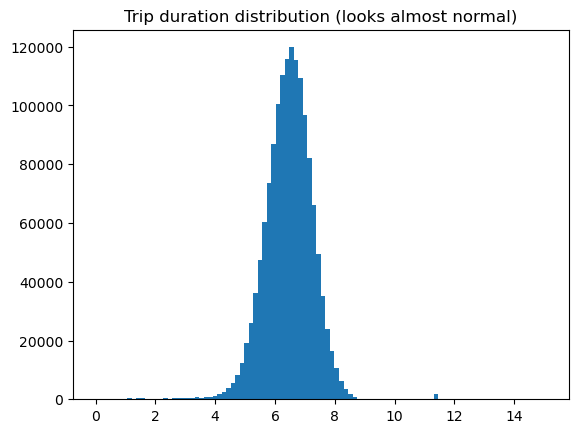

In [26]:
fig, ax = plt.subplots()
ax.hist(df_temp['trip_duration'], bins=100);
plt.title('Trip duration distribution (looks almost normal)');

In [27]:
df_temp.dropna(inplace=True)

#### We had only 17 missing data points

In [28]:
q1 = df_temp['trip_duration'].quantile(0.25)
q3 = df_temp['trip_duration'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
outliers = (df_temp['trip_duration'] < lower_bound) | (df_temp['trip_duration'] > upper_bound)

In [29]:
df_temp = df_temp[~outliers]
df_temp.shape

(1438889, 28)

In [30]:
df_temp['trip_duration'].skew()

-0.0875107588880019

In [31]:
df_temp.drop('id', axis=1, inplace=True)

## Splitting the data

In [99]:
X = df_temp.drop(['trip_duration'], axis=1)
y = df_temp['trip_duration']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

In [100]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Modelling

#### I have decided to use XGBoost as my model based on previous performances on this data set

### Hyperparamter tuning

In [101]:
model = xgb.XGBRegressor()


param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')


grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}


In [102]:
train_r2 = best_model.score(X_train_scaled, y_train)
y_train_pred = best_model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print(f'Training R^2 score: {train_r2}, Training MSE : {train_mse}, Training RMSE : {train_rmse}')

val_r2 = best_model.score(X_val_scaled, y_val)
y_val_pred = best_model.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
print(f'Validation R^2 score: {val_r2}, Validation MSE : {val_mse}, Validation RMSE : {val_rmse}')

test_r2 = best_model.score(X_test_scaled, y_test)
y_test_pred = best_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print(f'Test R^2 score: {test_r2}, Test MSE : {test_mse}, Test RMSE : {test_rmse}')


Training R^2 score: 0.930278027126414, Training MSE : 0.03538752030126067, Training RMSE : 0.1881157098736325
Validation R^2 score: 0.9294047526321363, Validation MSE : 0.03580126592572871, Validation RMSE : 0.18921222456735903
Test R^2 score: 0.9299649035732241, Test MSE : 0.03535880291185664, Test RMSE : 0.18803936532507398


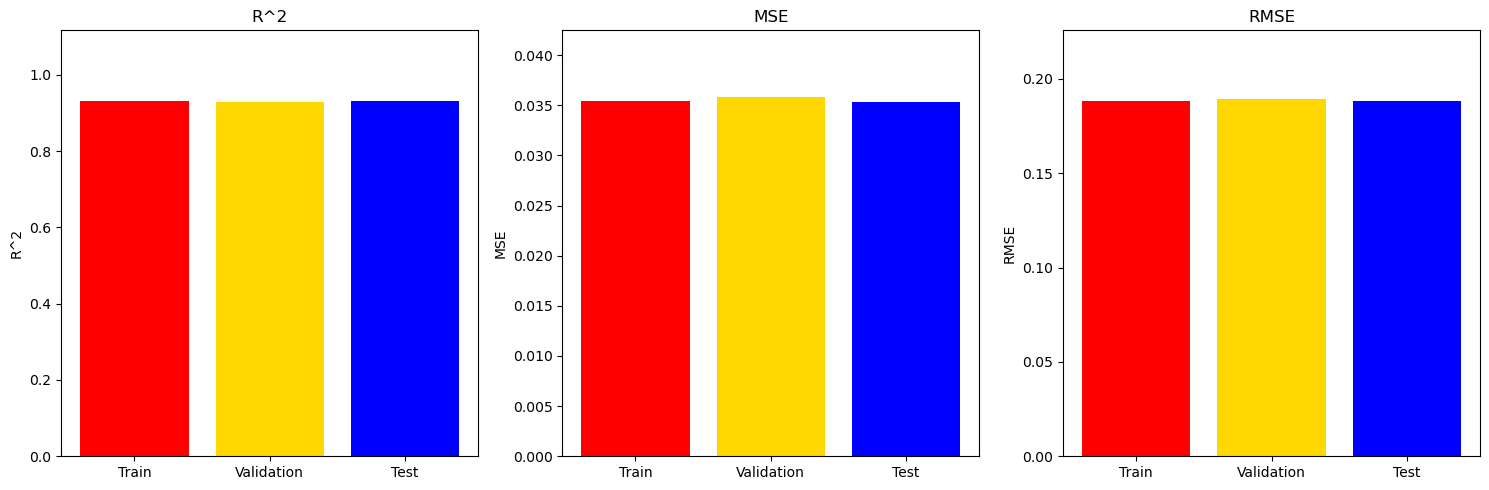

In [103]:
metrics = ['R^2', 'MSE', 'RMSE']
train_scores = [train_r2, train_mse, train_rmse]
val_scores = [val_r2, val_mse, val_rmse]
test_scores = [test_r2, test_mse, test_rmse]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    ax[i].bar(['Train', 'Validation', 'Test'], [train_scores[i], val_scores[i], test_scores[i]], color=['red', 'gold', 'blue'])
    ax[i].set_title(metric)
    ax[i].set_ylabel(metric)
    ax[i].set_ylim(0, max(train_scores[i], test_scores[i]) * 1.2)

plt.tight_layout()
plt.show()


#### No signs of overfitting 

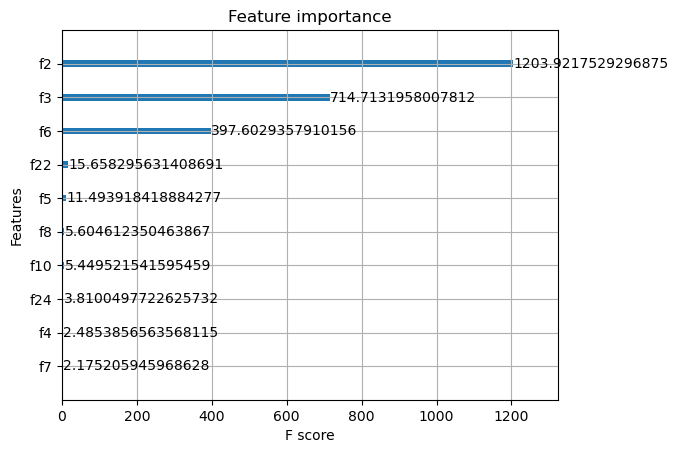

In [104]:
from xgboost import plot_importance

plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.show()


### Feature Importance Plot

The feature importance plot suggests that we gain the most information from the following features:

1. Distance without traffic
2. Duration without traffic
3. Speed

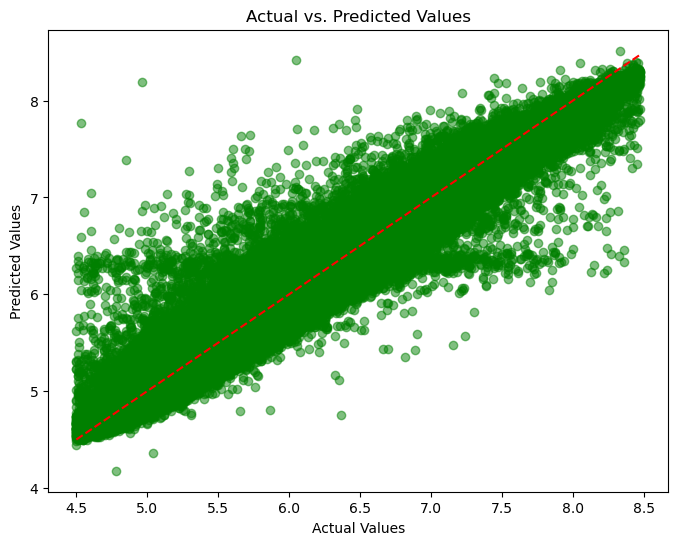

In [105]:
y_test_pred = best_model.predict(X_test_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

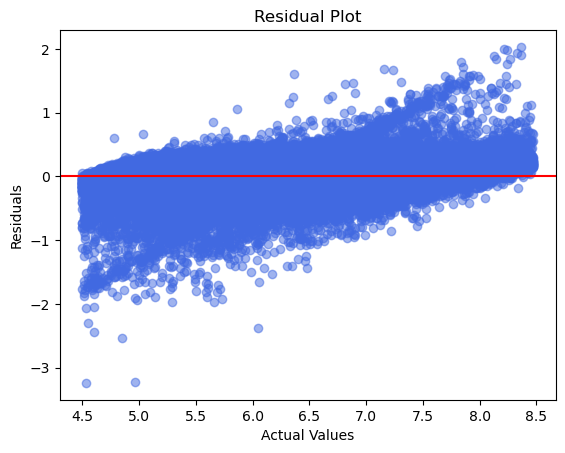

In [106]:
residuals = y_test - y_test_pred

plt.scatter(y_test, residuals, alpha=0.5, color='royalblue')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.show()